Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside your personal course repository for the course 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [254]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
from copy import deepcopy, copy
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm


## The *Nim* and *Nimply* classes

In [182]:
Nimply = namedtuple("Nimply", "row, num_objects")


In [183]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects


## Match
The match class is used to define one or more match between different strategies

In [233]:
class Match:
    def __init__(self, num_rows, player0, player1, verbose=False):
        self.nim = Nim(num_rows)
        self.strategies = (player0, player1)
        if verbose:
            logging.getLogger().setLevel(logging.DEBUG)
        else:
            logging.getLogger().setLevel(logging.INFO)
        
    def play(self, no_mark=False, starting_player=0):
        if no_mark:
            nim = deepcopy(self.nim)
        else:
             nim = self.nim
        player = starting_player
        logging.debug(f"init : {nim}")
        while nim:
            ply = self.strategies[player](nim)
            logging.debug(f"ply: player {player} plays {ply}")
            nim.nimming(ply)
            logging.debug(f"status: {nim}")
            player = 1 - player
        logging.debug(f"status: Player {player} won!")  
        return player
        
    def play_n(self, n_matches, change_starting_player=True):
        player0_win = 0
        player1_win = 0
        for i in range(n_matches):
            w = self.play(no_mark=True, starting_player=i%2 if change_starting_player else 0)
            if w == 0:
                player0_win += 1
            else:
                player1_win += 1
        logging.debug(f"Player 0 won {player0_win} times") 
        logging.debug(f"Player 1 won {player1_win} times")
        return player0_win, player1_win

## Sample (and silly) startegies 

In [205]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)


In [206]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))


In [207]:
def adaptive(state: Nim) -> Nimply:
    """A strategy that can adapt its parameters"""
    genome = {"love_small": 0.5}


In [208]:
def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    # logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply

## Expert agent (Task2.1)
### a.k.a. Real Optimal
An agent using fixed rules based on *nim-sum* that is the real optimal and always win

In [209]:
def real_optimal(state: Nim) -> Nimply:
    rows_with_more_than_two = [id for id, dim in enumerate(state.rows) if dim>=2]
    if len(rows_with_more_than_two) == 1:
        rows_with_one = len([None for dim in state.rows if dim==1])
        row_id = rows_with_more_than_two[0]
        if rows_with_one%2 == 0:
            return Nimply(row_id, state.rows[row_id] - 1)
        else:
            return Nimply(row_id, state.rows[row_id])
    else:
        analysis = analize(state)
        logging.debug(f"analysis:\n{pformat(analysis)}")
        spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns == 0]
        if not spicy_moves:
            spicy_moves = list(analysis["possible_moves"].keys())
        ply = random.choice(spicy_moves)
        return ply

## ES (Task2.2)

#### Rules
List of 6 rules that the Evolutionary Strategy will try to select based on an evolving probability.

In [228]:
########Util###########
def min_id_of_list(my_list, non_zero=False):
    if non_zero:
        lower = 0
        id = 0
        for i, val in enumerate(my_list):
            if (val < lower and val != 0) or lower == 0:
                lower = val
                id = i
        return  id
    else:
        return min(range(len(my_list)), key=my_list.__getitem__)

def max_id_of_list(my_list):
    return max(range(len(my_list)), key=my_list.__getitem__)
#######################


def empty_lower(state: Nim) ->Nimply:
    index = min_id_of_list(state.rows, non_zero=True)
    return Nimply(index, state.rows[index])
        
def empty_greater(state: Nim) ->Nimply:
    index = max_id_of_list(state.rows)
    return Nimply(index, state.rows[index])

def leave_one_to_lower(state: Nim) ->Nimply | None:
    index = min_id_of_list(state.rows, non_zero=True)
    if state.rows[index] == 1:
        return None
    return Nimply(index, state.rows[index] - 1)
def leave_one_to_greater(state: Nim) ->Nimply | None:
    index = max_id_of_list(state.rows)
    if state.rows[index] == 1:
        return None
    return Nimply(index, state.rows[index] - 1)

def remove_one_to_lower(state: Nim) ->Nimply:
    index = min_id_of_list(state.rows, non_zero=True)
    return Nimply(index, 1)

def remove_one_to_greater(state: Nim) ->Nimply:
    index = max_id_of_list(state.rows)
    return Nimply(index, 1)


rules = [empty_lower, empty_greater, leave_one_to_lower, leave_one_to_greater, remove_one_to_lower, remove_one_to_greater]

Agent that play the game, based on a list of probability

In [229]:
class Agent:
    def __init__(self, rules_probability, rules):
        self.rules_probability = rules_probability / sum(rules_probability)
        self.rules = rules
        
    def move(self, state: Nim) -> Nimply:
        #Every move a list of rules, ordered based on the evolute probability, are extracted and are applied until one of them give a valid result.
        rules_ordered = np.random.choice(self.rules, len(self.rules), replace=False, p=self.rules_probability)
        for rule in rules_ordered:
            out = rule(state)
            if out is not None:
                return out

Fitness function to evaluate the agent against a list of opponents

In [262]:
opponents = [gabriele, pure_random, optimal]
match_per_opponents = 15
row_count = 5

def fitness(agent):
    agent_win = 0
    for opponent in opponents:
        match = Match(row_count, agent.move, opponent)
        win_0, _ = match.play_n(match_per_opponents)
        agent_win += win_0
    return agent_win / (match_per_opponents * len(opponents))

### Adaptive (μ,λ)-ES

  0%|          | 0/200 [00:00<?, ?it/s]

INFO:root:Best solution: 0.8222222222222222


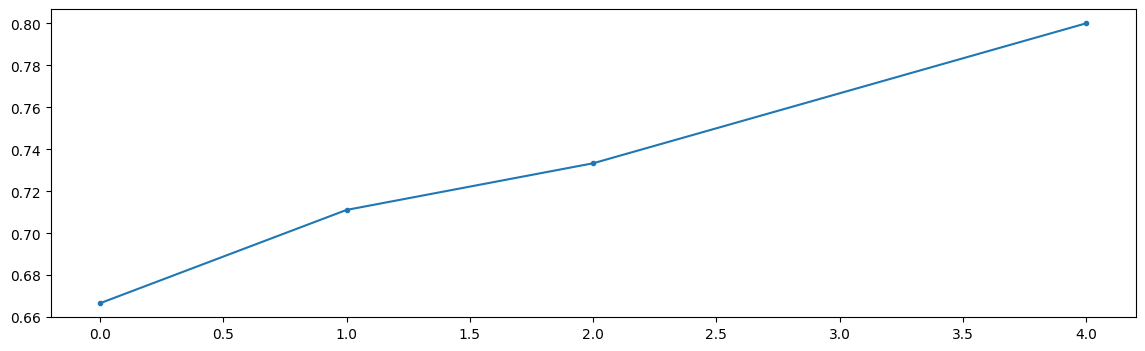

In [269]:
population_len = 15 #u
offspring_len = 100 #lambda
mu = 0.5
dimensions = len(rules) + 1
generations = 200 #1_000_000 // offspring_len

population = np.random.random((population_len, dimensions))
best_fitness = None
best_offspring = None
history = list()

for gen in tqdm(range(generations)):
    offspring = population[np.random.randint(0, population_len, size=(offspring_len, ))]
    
    #mutate mu
    offspring[:, -1] = np.random.normal(
            loc=offspring[:, -1], scale=0.2
        )
    #clamp the value of mu at 1e-5 (value of mu to low are not useful because lead to no mutation)
    offspring[offspring[:, -1] < 1e-5, -1] = 1e-5
    
    #mutate values
    offspring[:, 0:-1] = np.random.normal(
            loc=offspring[:, 0:-1], scale=offspring[:, -1].reshape(-1, 1)
        )
    #clamp the value of the values at 1e-5 (values lower than 0 are not valid probability)
    offspring[offspring < 1e-5] = 1e-5
    
    fit = np.array([fitness(Agent(offspring[i, 0:-1], rules)) for i in range(population_len)])
    offspring = offspring[fit.argsort()]
    
    if best_fitness is None or best_fitness < np.max(fit):
            best_fitness = np.max(fit)
            best_offspring = offspring[0,:-1]
            history.append((gen, best_fitness))
    population = np.copy(offspring[-population_len:])
    
logging.info(
    f"Best solution: {history[len(history) - 1][1]}"
)

history = np.array(history[:-1])
plt.figure(figsize=(14, 4))
plt.plot(history[:, 0], history[:, 1], marker=".")

# Result
### The result of the agent based on the evolutionary strategy is a 82.2% of win rate against the three standard opponent (gabriele, pure_random, optimal)